In [1]:
import pandas as pd
from gensim.models import LdaModel
from gensim import corpora
import seaborn as sns
import matplotlib.pylab as plt

In [2]:
file = pd.read_table('../steps/discretized_9.features', dtype=str)
nondisc = pd.read_table('../steps/nondiscretized_9.features')

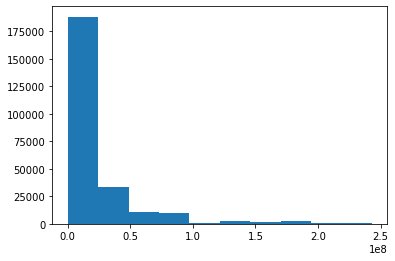

In [3]:
plt.hist(nondisc['SizeDipSeg'])
plt.show()

In [3]:
CIN = pd.read_table("/home/janneae/TCGA/DerivedData/TCGA_survival_data_clean.txt")

In [4]:
CIN.head()

,Unnamed: 0,bcr_patient_barcode,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,...,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
0,1,TCGA-OR-A5J1,ACC,58.0,MALE,WHITE,Stage II,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,1.0,1355.0,1.0,1355.0,1.0,754.0,1.0,754.0,NaN
1,2,TCGA-OR-A5J2,ACC,44.0,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,1.0,1677.0,1.0,1677.0,NaN,NaN,1.0,289.0,NaN
2,3,TCGA-OR-A5J3,ACC,23.0,FEMALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,0.0,2091.0,0.0,2091.0,1.0,53.0,1.0,53.0,NaN
3,4,TCGA-OR-A5J4,ACC,23.0,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,1.0,423.0,1.0,423.0,NaN,NaN,1.0,126.0,NaN
4,5,TCGA-OR-A5J5,ACC,30.0,MALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,1.0,365.0,1.0,365.0,NaN,NaN,1.0,50.0,NaN


In [5]:
lda = LdaModel.load(f'../steps/gensim/lda/lda_t5_f10.model')
file = pd.read_table('../steps/discretized_9.features', dtype=str)
df = file.drop(['Sample', 'Chr'], axis = 1)
listedDf = df.values.tolist()
dirichlet_dict = corpora.Dictionary(listedDf)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in listedDf]

In [6]:
def create_heatmap(model, df):
    topics = lda.get_document_topics(bow = bow_corpus, minimum_probability = 0)
    
    new_df = pd.DataFrame(df['Sample'])
    new_df['Chr'] = df['Chr']
    new_df['Chr'] = pd.to_numeric(new_df['Chr'])
    
    columns = [[],[],[],[],[]]
    for topic in topics:
        for w in topic:
            columns[w[0]].append(w[1])
    
    new_df['1'] = columns[0]
    new_df['2'] = columns[1]
    new_df['3'] = columns[2]
    new_df['4'] = columns[3]
    new_df['5'] = columns[4]
    new_df = new_df.sort_values(by='Chr')
    return new_df


In [7]:
weights_df = create_heatmap(lda, file)
heatmap_df = weights_df.drop('Sample', axis = 1).set_index('Chr').transpose()
heatmap_df

Chr,1,1,1,1,1,1,1,1,1,1,...,23,23,23,23,23,23,23,23,23,23
1,0.006071,0.006071,0.416273,0.006071,0.006071,0.006071,0.006071,0.006071,0.006071,0.969574,...,0.496563,0.006071,0.006071,0.969574,0.006071,0.969574,0.427749,0.006071,0.006071,0.006071
2,0.972194,0.972193,0.561992,0.008691,0.008691,0.008691,0.972194,0.972193,0.972193,0.008691,...,0.008691,0.972193,0.008691,0.008691,0.972194,0.008691,0.008691,0.008691,0.008691,0.008691
3,0.006532,0.006532,0.006532,0.006532,0.006532,0.006532,0.006532,0.006532,0.006532,0.006532,...,0.006532,0.006532,0.006532,0.006532,0.006532,0.006532,0.006532,0.587164,0.006532,0.864718
4,0.008711,0.008711,0.008711,0.972213,0.972213,0.972213,0.008711,0.008711,0.008711,0.008711,...,0.481721,0.008711,0.008711,0.008711,0.008711,0.008711,0.008711,0.391581,0.008711,0.008711
5,0.006493,0.006493,0.006493,0.006493,0.006493,0.006493,0.006493,0.006493,0.006493,0.006493,...,0.006493,0.006493,0.969996,0.006493,0.006493,0.006493,0.548318,0.006493,0.969996,0.111810


In [8]:
clusters = file['Chr'].unique()
palette = list(sns.color_palette("viridis", 23).as_hex())
color_mapping = dict(zip(clusters, palette))
cluster_colors = file['Chr'].map(color_mapping)

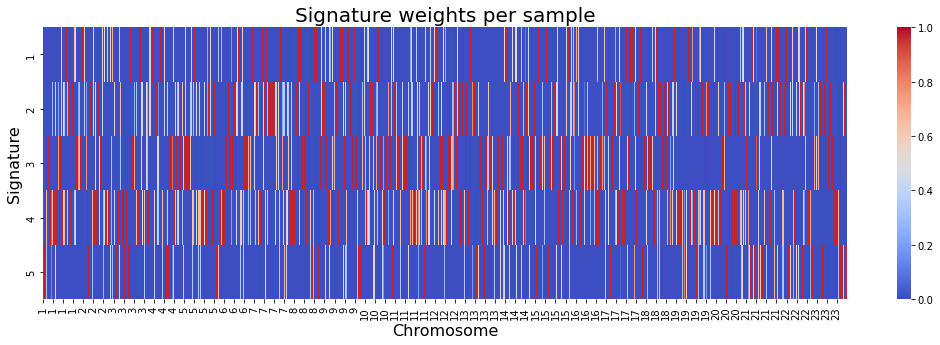

In [9]:
plt.figure(figsize=(18,5))
ax = sns.heatmap(heatmap_df, cmap='coolwarm', vmin=0, vmax=1)
ax.tick_params(axis="both", which="major", labelsize=10)
plt.xlabel('Chromosome', fontsize=16)
plt.ylabel('Signature', fontsize=16)
plt.title("Signature weights per sample", fontsize=20)
plt.savefig('../figures/heatmap.pdf')
plt.show()

In [10]:
weights_df.head()

,Sample,Chr,1,2,3,4,5
0,TCGA-02-0001,1,0.006071,0.972194,0.006532,0.008711,0.006493
55108,TCGA-AP-A054,1,0.006071,0.972193,0.006532,0.008711,0.006493
76107,TCGA-C4-A0F7,1,0.416273,0.561992,0.006532,0.008711,0.006493
99958,TCGA-DJ-A3US,1,0.006071,0.008691,0.006532,0.972213,0.006493
160885,TCGA-TS-A8AI,1,0.006071,0.008691,0.006532,0.972213,0.006493


In [13]:
cin.head()

,Sample,Unnamed: 0,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,...,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
0,TCGA-02-0001,2646.0,GBM,44.0,FEMALE,WHITE,[Not Available],[Not Applicable],Untreated primary (de novo) GBM,[Not Available],...,NaN,1.0,358.0,1.0,358.0,NaN,NaN,1.0,137.0,NaN
1,TCGA-AP-A054,10565.0,UCEC,64.0,FEMALE,WHITE,[Not Applicable],Stage IIIC1,Endometrioid endometrial adenocarcinoma,G3,...,NaN,1.0,709.0,1.0,709.0,1.0,566.0,1.0,566.0,NaN
2,TCGA-C4-A0F7,149.0,BLCA,77.0,MALE,[Not Available],Stage IV,[Not Applicable],Muscle invasive urothelial carcinoma (pT2 or a...,High Grade,...,NaN,1.0,62.0,1.0,62.0,NaN,NaN,1.0,62.0,Redacted
3,TCGA-DJ-A3US,9973.0,THCA,37.0,FEMALE,WHITE,Stage I,[Not Applicable],Thyroid Papillary Carcinoma - Classical/usual,[Not Available],...,R0,0.0,998.0,0.0,998.0,0.0,998.0,0.0,998.0,NaN
4,TCGA-TS-A8AI,6889.0,MESO,58.0,MALE,WHITE,Stage IV,[Not Applicable],Epithelioid mesothelioma,[Not Available],...,[Unknown],1.0,328.0,NaN,328.0,NaN,NaN,0.0,328.0,NaN


In [12]:
cin = CIN.set_index('bcr_patient_barcode')
cin = cin.reindex(index=weights_df['Sample'])
cin = cin.reset_index()
combined_df = weights_df.reset_index()
combined_df['Gender'] = cin['gender']
combined_df['Age_at_diagnosis'] = cin['age_at_initial_pathologic_diagnosis']
combined_df['Gender']=combined_df['Gender'].astype('category').cat.codes
combined_df.head()

,index,Sample,Chr,1,2,3,4,5,Gender,Age_at_diagnosis
0,0,TCGA-02-0001,1,0.006071,0.972194,0.006532,0.008711,0.006493,0,44.0
1,55108,TCGA-AP-A054,1,0.006071,0.972193,0.006532,0.008711,0.006493,0,64.0
2,76107,TCGA-C4-A0F7,1,0.416273,0.561992,0.006532,0.008711,0.006493,1,77.0
3,99958,TCGA-DJ-A3US,1,0.006071,0.008691,0.006532,0.972213,0.006493,0,37.0
4,160885,TCGA-TS-A8AI,1,0.006071,0.008691,0.006532,0.972213,0.006493,1,58.0


In [45]:
combined_df['5'].corr(combined_df['Gender'])

0.003978503219525371

In [53]:
combined_df['4'].corr(combined_df['Age_at_diagnosis'])

0.015139947257912262